In [1]:
import glob
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.time import Time
import numpy as np
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAnnulus
from astropy.wcs import WCS
from astropy.io import ascii

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from astropy.coordinates import SkyCoord
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

In [41]:
filenames = glob.glob("./*/*.wcs.proc.fits")
filenames.sort()
filenames = filenames
time_array = [fits.getheader(file)['DATE-OBS'] for file in filenames]
epochs = Time(time_array)

In [3]:
table_catalog = ascii.read('AAVSO200_Catalog.txt')
table_catalog2 = ascii.read('Catalog2.txt')



In [4]:
zpb_array = []
vbu_mag_array = []
phase_array = []
total_err_array =[]
image_arr =[]
for file in filenames:
    data = fits.getdata(file)
    header = fits.getheader(file)
    time= fits.getheader(file)['DATE-OBS']
    epoch_obs= Time(time) 
    epoch_obs = (epoch_obs - epochs[0]).jd
    mean, med, std = sigma_clipped_stats(data.flatten(),sigma = 3, maxiters = 10)
    w = WCS(header)
    target_coord = SkyCoord("12h35m55s","82d41m52s")
    target_pix =w.all_world2pix(target_coord.ra.degree, target_coord.dec.degree,1)
    x,y = target_pix
    
    daofind = DAOStarFinder(fwhm=10.57,threshold = 4*std,exclude_border=True)
    sources =daofind(data-med)
    
    aperture = CircularAperture([x,y],r=5)
    annulus_aperture=CircularAnnulus([x,y],r_in =12, r_out = 14)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(data, apers)
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_sum = bkg_mean * aperture.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    mag_vbu = -2.5*np.log10(phot_table['residual_aperture_sum'])
    
    
    sigma_clip = SigmaClip(sigma=3.)
    bkg_estimator = MedianBackground()
    bkg = Background2D(data, (50, 50), filter_size=(3, 3),
    sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
    effective_gain =120
    ratio = 0.5714285714285714**2
    from photutils.utils import calc_total_error
    error = calc_total_error(data, np.array(bkg.background), effective_gain)    
    phot_table = aperture_photometry(data-bkg.background, apers, error=error) 
    mag_vbu_err = np.abs(2.5*np.sqrt(phot_table['aperture_sum_err_1']**2 + ratio*phot_table['aperture_sum_err_0']**2)/final_sum)
    
    
    source_pix = np.c_[sources['xcentroid'].data,sources['ycentroid'].data]
    source_coords = w.all_pix2world(*source_pix.T,1)
    aperture = CircularAperture(source_pix,r=5)
    annulus_aperture=CircularAnnulus(source_pix,r_in =12, r_out = 14)  
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(data, apers)
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_sum = bkg_mean * aperture.area
    final_sum = phot_table['aperture_sum_0'] - bkg_sum
    phot_table['residual_aperture_sum'] = final_sum
    a = phot_table['residual_aperture_sum']
    mag_sources = a
    mag_sources = -2.5*np.log10(mag_sources[mag_sources>0])
    
    phot_table_new = []
    i = 0
    for x in phot_table:
         if(x[5]>0):
            coords_pix = np.c_[x[1].data,x[2].data] 
            coords_RADEC= w.all_pix2world(*coords_pix.T,1)
            append_array = np.array([coords_RADEC[0][0],coords_RADEC[1][0],mag_sources[i]])
            phot_table_new.append(append_array)
            i = i+1
    matched_sources = []
    for img_source in phot_table_new:
        for catalog_source in table_catalog:
            if((np.abs(img_source[0]- catalog_source[0]) <0.0004) and (np.abs(img_source[1]- catalog_source[1]) <0.0004)):
                 matched_sources.append([catalog_source[0],catalog_source[1],(catalog_source[2]-img_source[2]),catalog_source[2],img_source[2]]) 
                    
    for img_source in phot_table_new:
        for catalog_source in table_catalog2:
            if((np.abs(img_source[0]- catalog_source[0]) <0.0004) and (np.abs(img_source[1]- catalog_source[1]) <0.0004)):
                matched_sources.append([catalog_source[0],catalog_source[1],(catalog_source[2]-img_source[2]),catalog_source[2],img_source[2]]) 
    ZPB = np.array(matched_sources)[:,2]
    ZPB = np.ma.array(ZPB).compressed()
    std_dev_ZPB = np.std(ZPB)
    x = np.array(matched_sources)[:,3]
    idx =x.argsort()
    x = np.sort(x)
    y = np.array(matched_sources)[:,4]
    y = y[idx]
    m, b = np.polyfit(x, y, 1)
    image_arr.append([x,y,m*x+b])
 
    total_error = np.sqrt(mag_vbu_err**2 + std_dev_ZPB**2)
        
    mean_ZPB = np.average(ZPB)
    zpb_array.append(mean_ZPB)
    vbu_mag_array.append(mag_vbu[0])
    phase_array.append(epoch_obs)
    total_err_array.append(total_error)

C:\Users\Roshni Singh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Roshni Singh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Roshni Singh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\Roshni Singh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


0.4372901388888889


5.416549928604777e-10

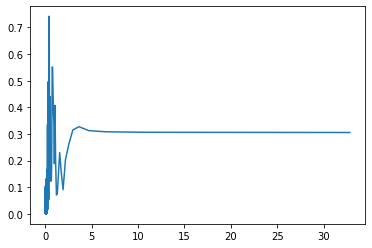

In [63]:
len(zpb_array)
phase_array_copy = np.delete(phase_array,[5,6,7,8,9,15,16,17,26,27,30,41,48])
final_mag_vbu = np.array(np.array(zpb_array)+vbu_mag_array)
vbu_mags = np.delete(final_mag_vbu,[5,6,7,8,9,15,16,17,26,27,30,41,48])
backup_err1 = np.array(total_err_array).flatten()
backup_err =np.delete(backup_err1,[5,6,7,8,9,15,16,17,26,27,30,41,48])

from astropy.timeseries import LombScargle
frequency, power = LombScargle(phase_array_copy, vbu_mags).autopower()
import matplotlib.pyplot as plt  
plt.plot(1/frequency, power) 
print(1/frequency[np.argmax(power)])


model.false_alarm_probability(power.max(), method='baluev') 

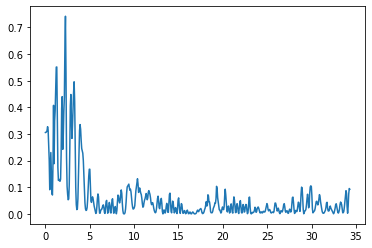

In [64]:
plt.plot(frequency, power) 

In [65]:
model = LombScargle(phase_array_copy, vbu_mags, backup_err, nterms=5)
freq, power = model.autopower(samples_per_peak=30, method='chi2',minimum_frequency=2, maximum_frequency=2.5,)
print(1/freq[np.argmax(power)])


0.44164661470409927


In [67]:
final_mag_vbu = np.array(np.array(zpb_array)+vbu_mag_array)


In [68]:
np.array(total_err_array).flatten()
i = -1
for element in total_err_array:
    i = i+1
    if(element>0.3):
        print(element[0],i)    

0.6029189228976815 15
1.004978857812974 16
1.231526836843095 26
0.3488591827131229 27
0.30394877529204717 30
0.340405748313848 41


In [69]:
backup_arr = final_mag_vbu
backup_arr = np.delete(backup_arr,[5,6,7,8,9,15,16,17,26,27,30,41,48])
print(np.average(backup_arr))


14.09257439284981


In [70]:
print(np.max(backup_arr)-np.min(backup_arr))
print(len(backup_arr))

1.0524777672342598
45


In [71]:
period = 0.4416
phase = np.remainder(phase_array_copy, period)/period
phase_backup = phase


In [72]:
print(backup_arr)
print(np.sum(np.square(backup_err)))
print(np.sqrt(0.942760003680648))
print(0.970958291421752/45)

[14.33519443 14.27774136 14.2933764  14.31293936 13.51811034 14.23268265
 14.28951866 14.42869752 14.33179888 14.37945454 13.45108172 13.52701241
 13.51805616 13.71794747 13.63862158 13.82479726 13.76787971 13.83173006
 13.89862628 13.87204765 14.33380319 14.38596318 14.50355949 14.40802053
 13.97090241 14.25359027 14.32440095 14.28370293 14.222768   14.17438321
 14.25848506 14.14139143 13.93943787 14.18004454 14.15276942 14.46465467
 13.97758268 14.1260867  14.00219784 14.04967187 14.0565466  14.08235007
 14.12242506 14.13174544 14.17204984]
0.9319594274058446
0.970958291421752
0.02157685092048338


In [73]:
idx = np.array(phase_backup).argsort()

In [74]:
total_err = np.array(total_err_array).flatten()
len(final_mag_vbu)

58

In [75]:
backup_arr = backup_arr[idx]
backup_err = backup_err[idx]

In [76]:

print(np.average(backup_arr))


14.092574392849807


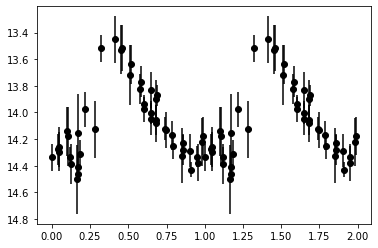

In [77]:
plt.errorbar(np.sort(phase_backup),backup_arr,yerr=backup_err,fmt='o',color = 'black')
#plt.plot(np.sort(phase_backup),backup_arr,'--',color = 'r')
plt.errorbar(np.sort(phase_backup+1),backup_arr,yerr=backup_err,fmt='o',color='black')
#plt.plot(np.sort(phase_backup+1),backup_arr,'--',color ='r')
#plt.scatter(np.sort(phase_backup+1),backup_arr)
plt.gca().invert_yaxis()

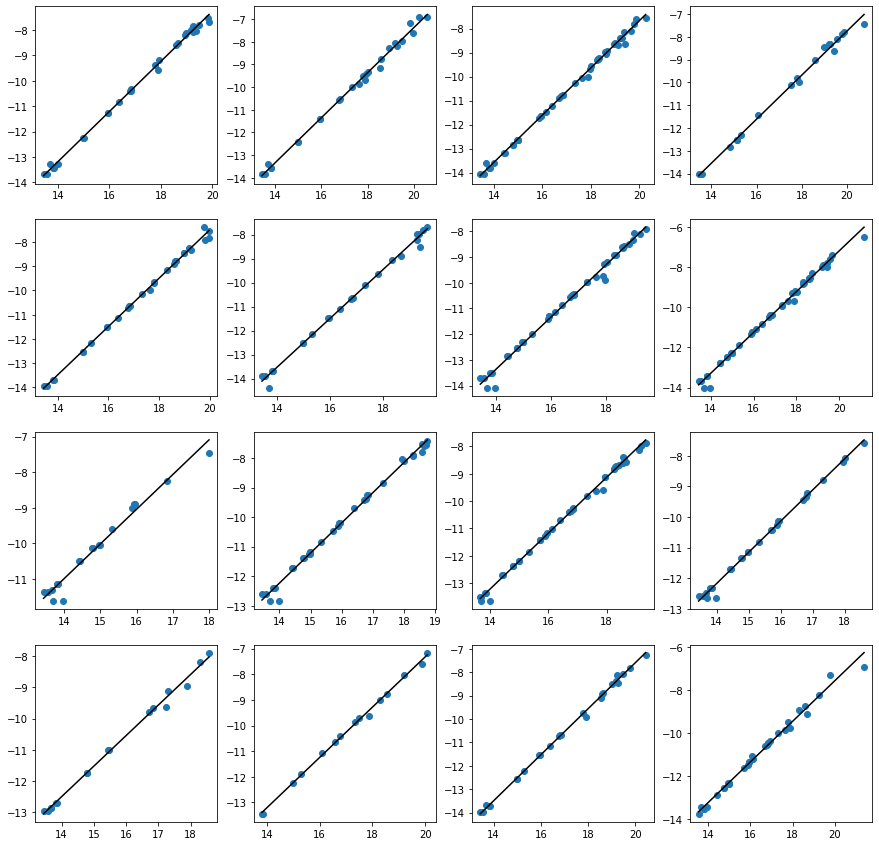

In [78]:
fig, axs = plt.subplots(4, 4,figsize = (15,15))
n = 0
for i in range (4):
    for j in range (4):
        while(len(image_arr[n][0])<15):
            n = n+1
        x= image_arr[n][0]
        y= image_arr[n][1]
        z = image_arr[n][2]
        axs[i, j].scatter(x, y)
        axs[i,j].plot(x,z,color='black')
        n = n+1

In [79]:
print(np.shape(np.array(image_arr)))

(58, 3)


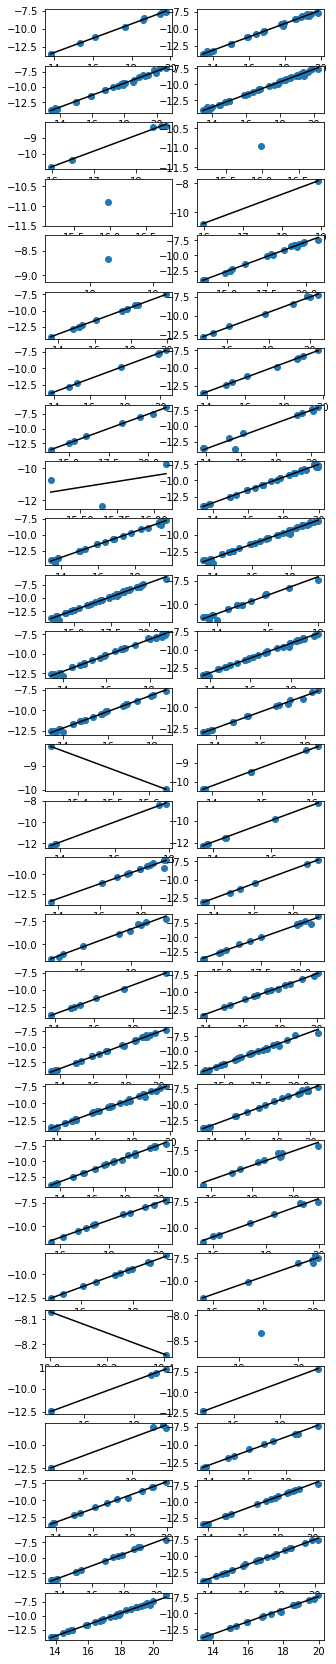

In [35]:
fig, axs = plt.subplots(29, 2,figsize = (5,30))
n = 0
for i in range (29):
    for j in range (2):
        x= image_arr[n][0]
        y= image_arr[n][1]
        z = image_arr[n][2]
        axs[i, j].scatter(x, y)
        axs[i,j].plot(x,z,color='black')
        n = n+1

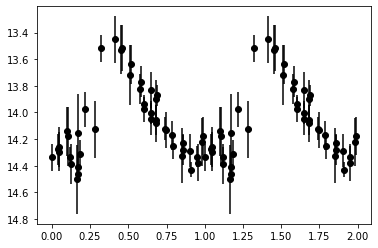

In [36]:
plt.errorbar(np.sort(phase_backup),backup_arr,yerr=backup_err,fmt='o',color = 'black')
#plt.plot(np.sort(phase_backup),backup_arr,'--',color = 'r')
plt.errorbar(np.sort(phase_backup+1),backup_arr,yerr=backup_err,fmt='o',color='black')
#plt.plot(np.sort(phase_backup+1),backup_arr,'--',color ='r')
#plt.scatter(np.sort(phase_backup+1),backup_arr)
plt.gca().invert_yaxis()

In [80]:
np.argmax(backup_arr)

8

In [37]:
backup_err[8]

0.25885696703011835

In [38]:
np.argmin(backup_arr)

16

In [39]:
backup_err[16]

0.1741469892120483